In [180]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis`


Status `~/Documents/Carnegie-Mellon/Chatterjee Group/Programming/heisenberg-model/Biquadratic.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.3
⌃ [780c37f4] Carlo v0.2.4
  [a93c6f00] DataFrames v1.7.0
  [f67ccb44] HDF5 v0.17.2
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [181]:
using CairoMakie
using Carlo.ResultTools
using DataFrames
using HDF5
using LinearAlgebra

In [182]:
# Parse DataFrame from ResultTools into more readily useable form
cleandata(filepath::AbstractString) = select(
    DataFrame(ResultTools.dataframe(filepath)),
    [:T, :K, :Lx, :Ly, :Mag, :Energy, :Dxπ, :Dyπ, :P],
)

cleandata (generic function with 1 method)

In [183]:
function generatePlot(data::AbstractDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false, label="")
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals; label)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return fig
end

function generatePlot(data::GroupedDataFrame, x, y; fig=Figure(), fig_pos=(1,1),
                      title, xlabel, ylabel, line=false)
    fig = Figure()
    fig[fig_pos...] = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return fig
end

generatePlot (generic function with 2 methods)

In [184]:
jobname = "temp-sweep"
data = groupby(cleandata("../jobs/" * jobname * ".results.json"), [:K])

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.00147±9.9e-5,-1.99502±4.3e-5,0.98899±0.00022,0.98895±0.00022,0.041±0.0011
2,0.05,-0.005,40,40,0.00346±0.00012,-1.95504±0.00016,0.9429±0.001,0.9429±0.001,0.0877±0.0067
3,0.1,-0.005,40,40,0.004987±9.9e-5,-1.90369±0.00024,0.8864±0.0018,0.8864±0.0018,0.04±0.0033
4,0.15,-0.005,40,40,0.005906±8.7e-5,-1.85234±0.00029,0.8108±0.0045,0.8106±0.0045,0.166±0.018
5,0.2,-0.005,40,40,0.00707±0.00013,-1.79924±0.0004,0.762±0.007,0.762±0.007,0.145±0.018
6,0.25,-0.005,40,40,0.00784±0.00011,-1.74537±0.00054,0.6904±0.008,0.6902±0.008,0.148±0.022
7,0.3,-0.005,40,40,0.00871±0.00012,-1.69022±0.00059,0.575±0.011,0.575±0.011,0.211±0.018
8,0.35,-0.005,40,40,0.009381±9.0e-5,-1.63369±0.0004,0.5725±0.0086,0.5723±0.0086,0.135±0.016
9,0.4,-0.005,40,40,0.01038±0.00011,-1.57635±0.00054,0.473±0.014,0.473±0.014,0.18±0.024


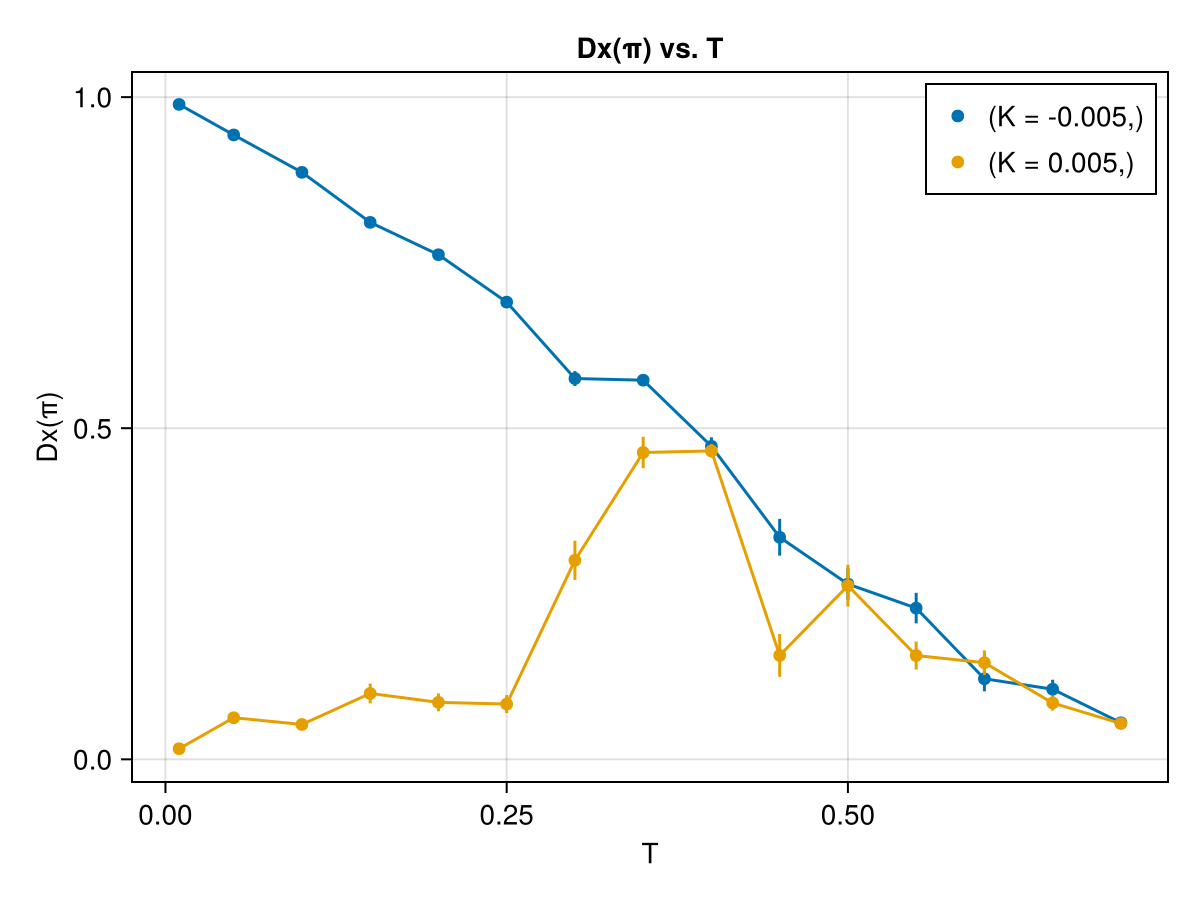

In [185]:
fig = generatePlot(
    data, :T, :Dxπ;
    title="Dx(π) vs. T",
    xlabel="T",
    ylabel="Dx(π)",
    line=true
)

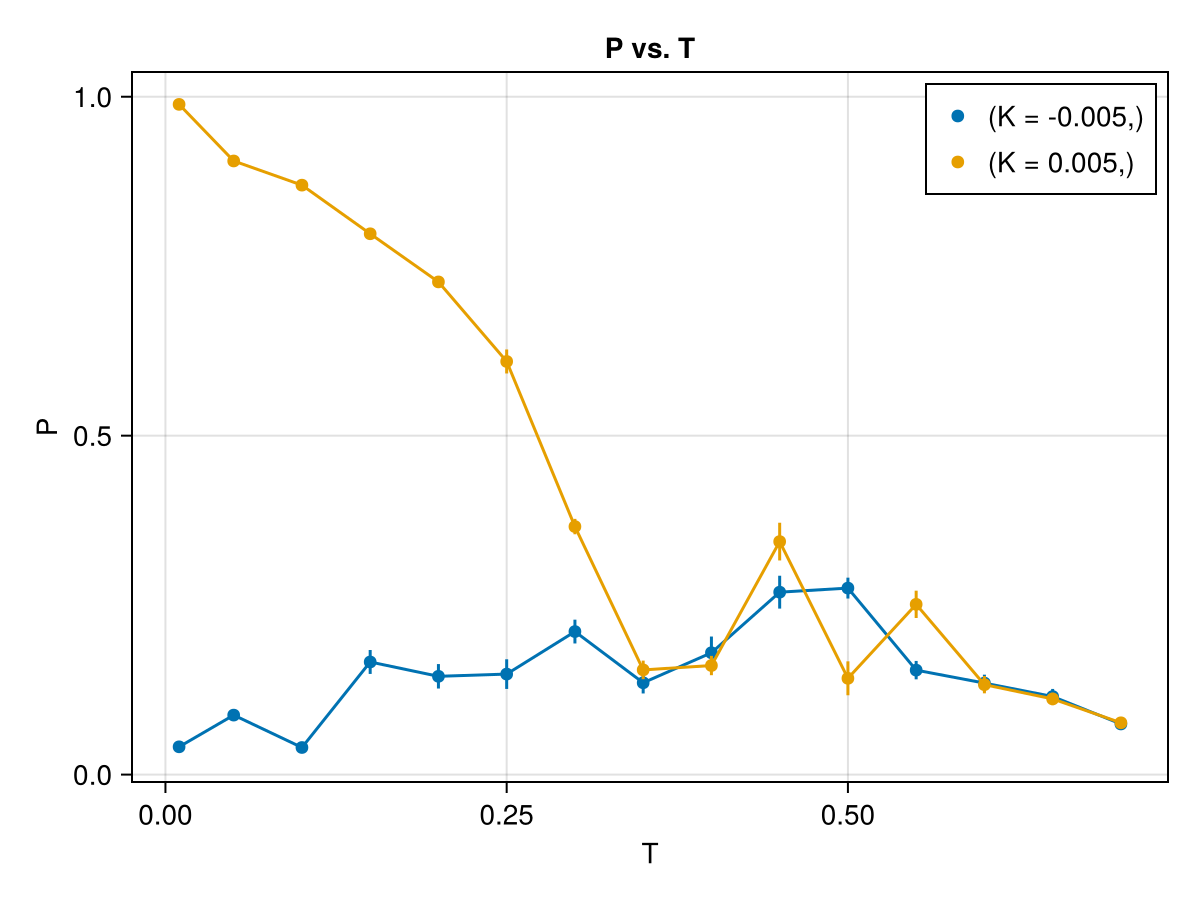

In [186]:
fig = generatePlot(
    data, :T, :P;
    title="P vs. T",
    xlabel="T",
    ylabel="P",
    line=true
)

In [187]:
ungrouped_data = cleandata("../jobs/$jobname.results.json")

Row,T,K,Lx,Ly,Mag,Energy,Dxπ,Dyπ,P
,Float64,Float64,Int64,Int64,Measurem…,Measurem…,Measurem…,Measurem…,Measurem…
1,0.01,-0.005,40,40,0.00147±9.9e-5,-1.99502±4.3e-5,0.98899±0.00022,0.98895±0.00022,0.041±0.0011
2,0.05,-0.005,40,40,0.00346±0.00012,-1.95504±0.00016,0.9429±0.001,0.9429±0.001,0.0877±0.0067
3,0.1,-0.005,40,40,0.004987±9.9e-5,-1.90369±0.00024,0.8864±0.0018,0.8864±0.0018,0.04±0.0033
4,0.15,-0.005,40,40,0.005906±8.7e-5,-1.85234±0.00029,0.8108±0.0045,0.8106±0.0045,0.166±0.018
5,0.2,-0.005,40,40,0.00707±0.00013,-1.79924±0.0004,0.762±0.007,0.762±0.007,0.145±0.018
6,0.25,-0.005,40,40,0.00784±0.00011,-1.74537±0.00054,0.6904±0.008,0.6902±0.008,0.148±0.022
7,0.3,-0.005,40,40,0.00871±0.00012,-1.69022±0.00059,0.575±0.011,0.575±0.011,0.211±0.018
8,0.35,-0.005,40,40,0.009381±9.0e-5,-1.63369±0.0004,0.5725±0.0086,0.5723±0.0086,0.135±0.016
9,0.4,-0.005,40,40,0.01038±0.00011,-1.57635±0.00054,0.473±0.014,0.473±0.014,0.18±0.024


In [188]:
function generate_mctime_plot(task_no::Int)
    fig = Figure(size=(800, 400))

    ax_P = fig[1,1] = Axis(
        fig,
        title="P vs. Bin #",
        xlabel="Bin #",
        ylabel="P",
        xminorticksvisible=true
    )
    ax_Dxπ = fig[1,2] = Axis(
        fig,
        title="Dx(π) vs. Bin #",
        xlabel="Bin #",
        ylabel="Dx(π)",
        xminorticksvisible=true
    )

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.meas.h5") do file
        observables = file["observables"]
        P_samples = read(observables, "P/samples")
        n = length(P_samples)
        init = 1
        lines!(
            ax_P,
            collect(init:n),
            P_samples[init:n],
        )
        Dxπ_samples = read(observables, "Dxπ/samples")
        lines!(
            ax_Dxπ,
            collect(init:n),
            Dxπ_samples[init:n],
        )
    end

    return fig
end

generate_mctime_plot (generic function with 1 method)

DataFrameRow
 Row │ T        K        Lx     Ly     Mag             Energy            Dxπ          Dyπ          P           
     │ Float64  Float64  Int64  Int64  Measurem…       Measurem…         Measurem…    Measurem…    Measurem…   
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────
  26 │     0.5    0.005     40     40  0.01177±0.0001  -1.44921±0.00074  0.262±0.032  0.262±0.032  0.142±0.025

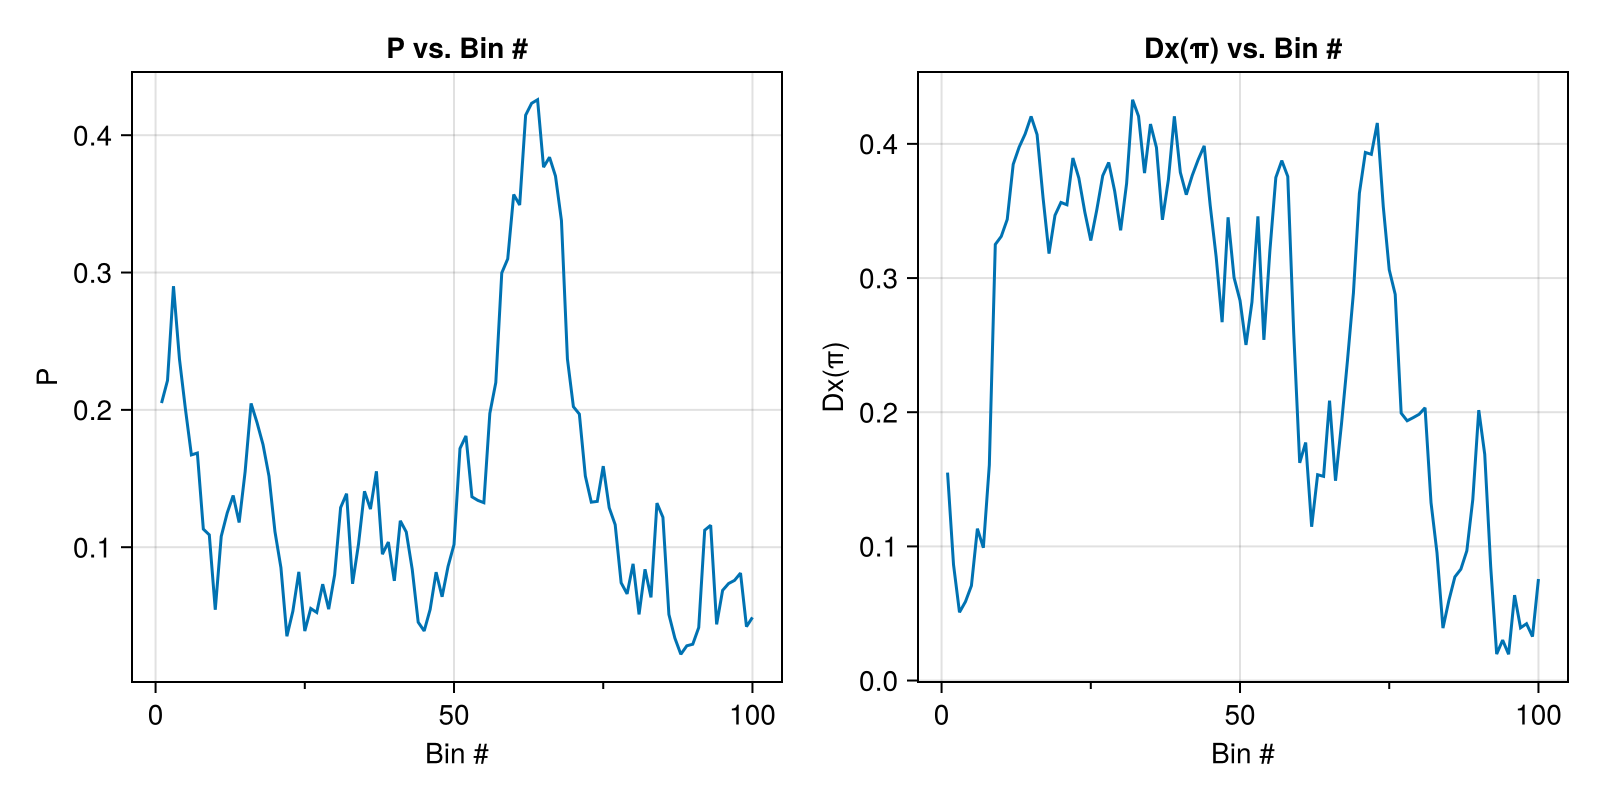

In [191]:
i = 26
print(ungrouped_data[i, :])
generate_mctime_plot(i)

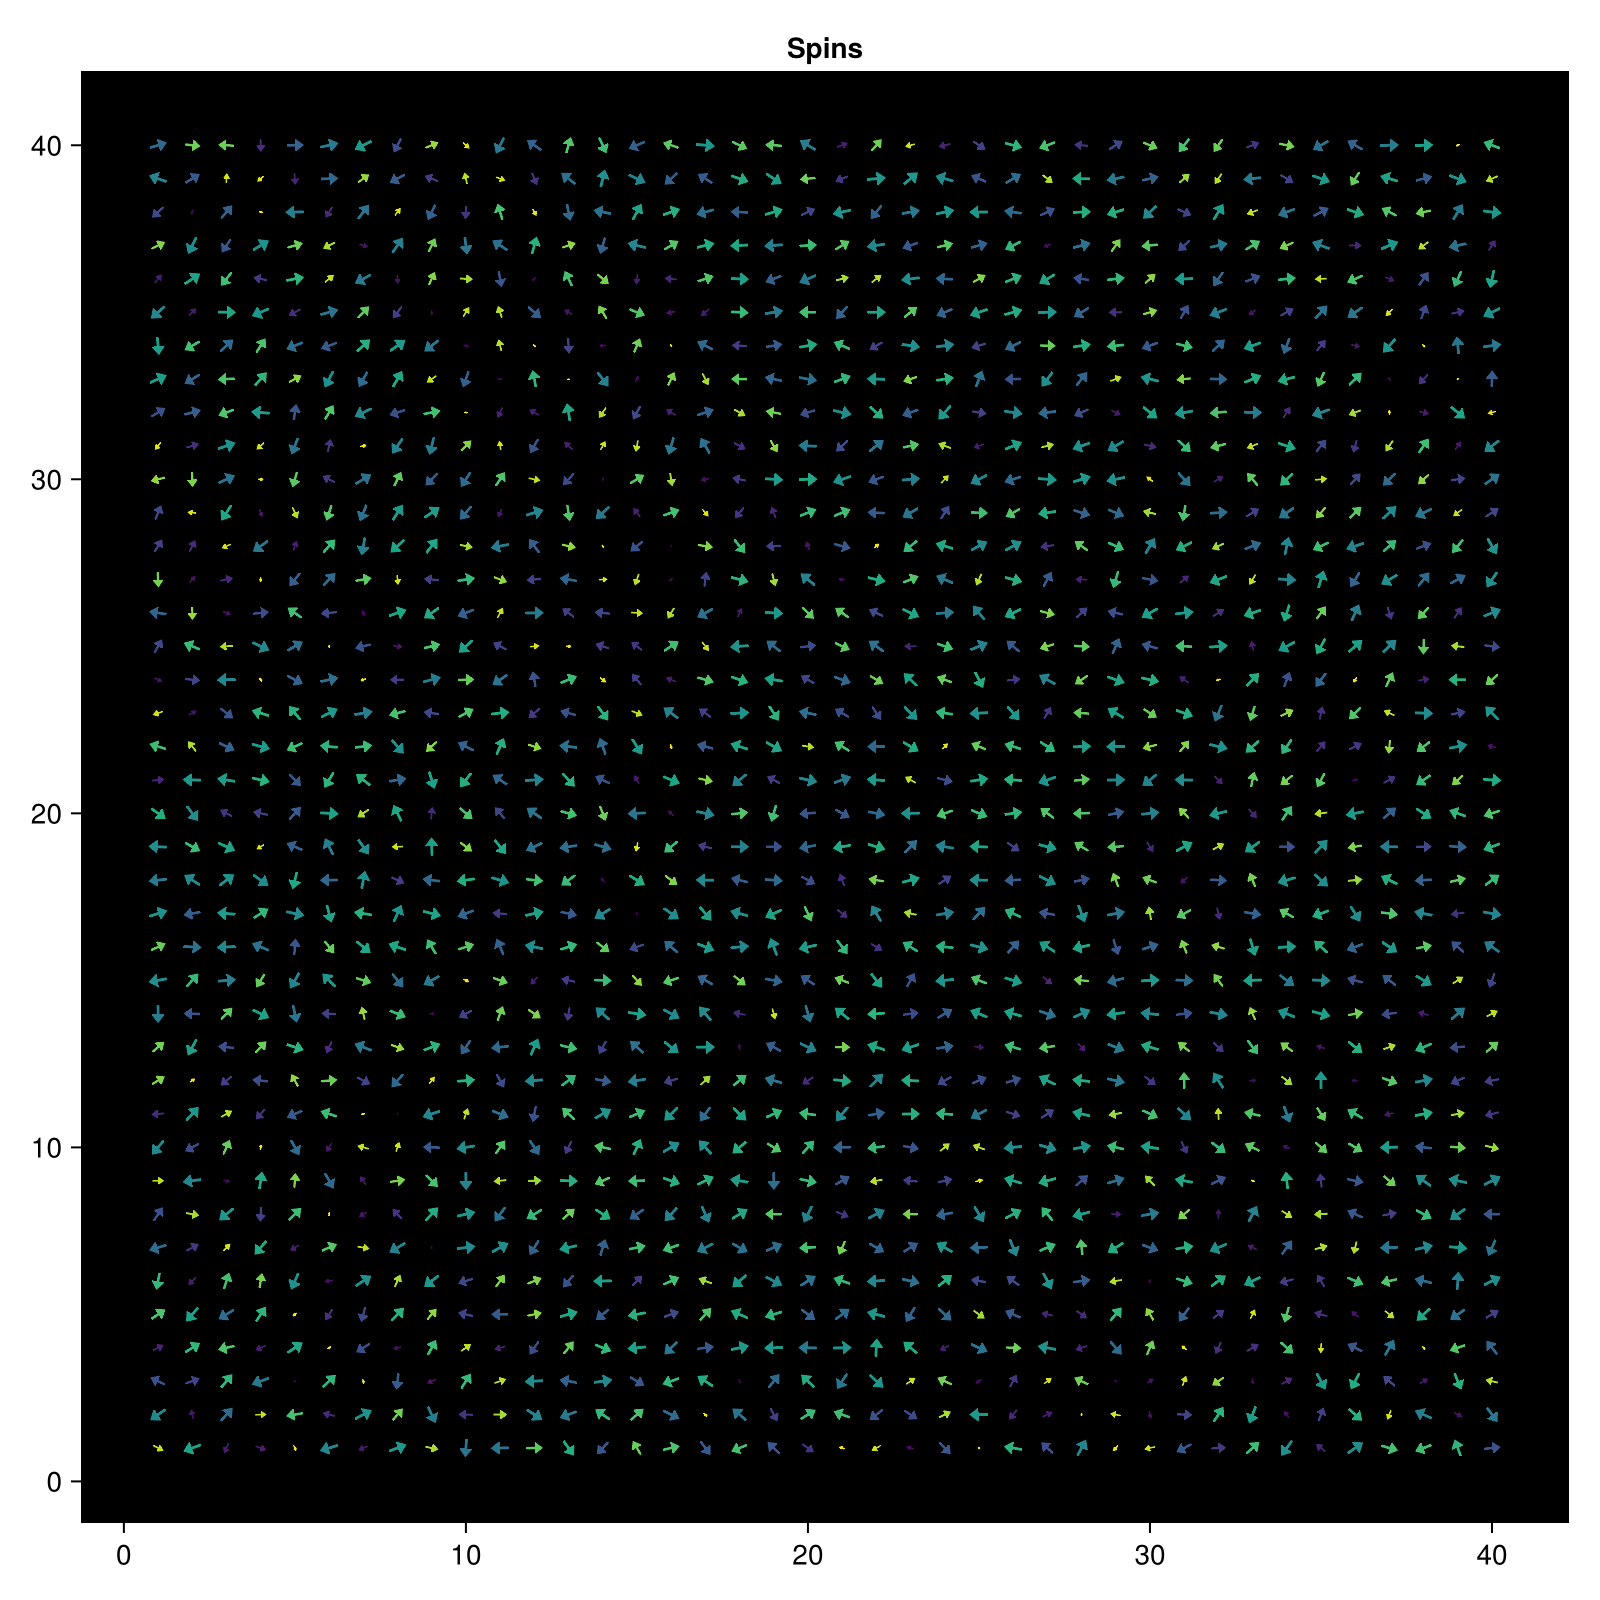

In [190]:
task_no = "10"
file = h5open("../jobs/$jobname.data/task00" * task_no * "/run0001.dump.h5")
spins = map(
    t -> [t[:data][1], t[:data][2], t[:data][3]],
    read(file, "simulation/spins")
)
spin_xs = map(v -> v[1], spins)
spin_ys = map(v -> v[2], spins)
spin_zs = map(v -> v[3], spins)
Lx, Ly = size(spins)
close(file)

fig = Figure(size=(800, 800))
fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")

strength = vec(spin_zs)
arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength)
fig